In [1]:
from backtesting.test import SMA
from backtesting import Strategy
from backtesting import Backtest

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from directional_change import directional_change, get_extremes
from dataclasses import dataclass
from typing import Union
from math import log

@dataclass
class XABCD:
    XA_AB: Union[float, list, None]
    AB_BC: Union[float, list, None]
    BC_CD: Union[float, list, None]
    XA_AD: Union[float, list, None]
    name: str

# Define Patterns
GARTLEY = XABCD(0.618, [0.382, 0.886], [1.13, 1.618], 0.786, "Gartley")
BAT = XABCD([0.382, 0.50], [0.382, 0.886], [1.618, 2.618], 0.886, "Bat")
#ALT_BAT = XABCD(0.382, [0.382, 0.886], [2.0, 3.618], 1.13, "Alt Bat")
BUTTERFLY = XABCD(0.786, [0.382, 0.886], [1.618, 2.24], [1.27, 1.41], "Butterfly")
CRAB = XABCD([0.382, 0.618], [0.382, 0.886], [2.618, 3.618], 1.618, "Crab")
DEEP_CRAB = XABCD(0.886, [0.382, 0.886], [2.0, 3.618], 1.618, "Deep Crab")
CYPHER = XABCD([0.382, 0.618], [1.13, 1.41], [1.27, 2.00], 0.786, "Cypher")
SHARK = XABCD(None, [1.13, 1.618], [1.618, 2.24], [0.886, 1.13], "Shark")
ALL_PATTERNS = [GARTLEY, BAT, BUTTERFLY, CRAB, DEEP_CRAB, CYPHER, SHARK]

@dataclass
class XABCDFound:
    X: int
    A: int
    B: int
    C: int
    D: int # Index of last point in pattern, the entry is on the close of D
    error: float # Error found
    name: str
    bull: bool

def plot_pattern(ohlc: pd.DataFrame, pat: XABCDFound, pad=3):
    idx = ohlc.index
    data = ohlc.iloc[pat.X - pad: pat.D + 1 + pad]

    plt.style.use('dark_background')
    fig = plt.gcf()
    ax = fig.gca()

    if pat.bull:
        s1 = ohlc['low'].to_numpy()
        s2 = ohlc['high'].to_numpy()
    else:
        s2 = ohlc['low'].to_numpy()
        s1 = ohlc['high'].to_numpy()
        

    l0 = [(idx[pat.X], s1[pat.X]), (idx[pat.A], s2[pat.A])]
    l1 = [(idx[pat.A], s2[pat.A]), (idx[pat.B], s1[pat.B])]
    l2 = [(idx[pat.B], s1[pat.B]), (idx[pat.C], s2[pat.C])]
    l3 = [(idx[pat.C], s2[pat.C]), (idx[pat.D], s1[pat.D])]
    
    # Connecting lines
    l4 = [(idx[pat.A], s2[pat.A]), (idx[pat.C], s2[pat.C])]
    l5 = [(idx[pat.B], s1[pat.B]), (idx[pat.D], s1[pat.D])]
    l6 = [(idx[pat.X], s1[pat.X]), (idx[pat.B], s1[pat.B])]
    l7 = [(idx[pat.X], s1[pat.X]), (idx[pat.D], s1[pat.D])]
    
    # Text
    xa_ab =  abs(s2[pat.A] - s1[pat.B]) / abs(s1[pat.X] - s2[pat.A])
    ab_bc =  abs(s1[pat.B] - s2[pat.C]) / abs(s2[pat.A] - s1[pat.B])
    bc_cd =  abs(s2[pat.C] - s1[pat.D]) / abs(s1[pat.B] - s2[pat.C])
    xa_ad =  abs(s2[pat.A] - s1[pat.D]) / abs(s1[pat.X] - s2[pat.A])
    ax.text(int((pat.X + pat.B) / 2) - pat.X + pad, (s1[pat.X] + s1[pat.B]) / 2 , str(round(xa_ab, 3)), color='orange', fontsize='x-large')
    ax.text(int((pat.A + pat.C) / 2) - pat.X + pad, (s2[pat.A] + s2[pat.C]) / 2 , str(round(ab_bc, 3)), color='orange', fontsize='x-large')
    ax.text(int((pat.B + pat.D) / 2) - pat.X + pad, (s1[pat.B] + s1[pat.D]) / 2 , str(round(bc_cd, 3)), color='orange', fontsize='x-large')
    ax.text(int((pat.X + pat.D) / 2) - pat.X + pad, (s1[pat.X] + s1[pat.D]) / 2 , str(round(xa_ad, 3)), color='orange', fontsize='x-large')
    
    desc_string = pat.name
    desc_string += "\nError: " + str(round(pat.error , 5))
    if pat.bull:
        plt_price = data['high'].max() - 0.05 * (data['high'].max() - data['low'].min())
    else:
        plt_price = data['low'].min() + 0.05 * (data['high'].max() - data['low'].min())
    ax.text(0, plt_price , desc_string, color='yellow', fontsize='x-large')
    plt.show()

def get_error(actual_ratio: float, pattern_ratio: Union[float, list, None]):
     
    if pattern_ratio is None: # No requirement (Shark)
        return 0.0

    log_actual = log(actual_ratio)

    if isinstance(pattern_ratio, list): # Acceptable range
        log_pat0 = log(pattern_ratio[0])
        log_pat1 = log(pattern_ratio[1])
        assert(log_pat1 > log_pat0)

        if log_pat0 <= log_actual <= log_pat1:
            return 0.0
        #else:
        #    return 1e20

        err = min( abs(log_actual - log_pat0), abs(log_actual - log_pat1) )
        range_mult = 2.0 # Since range is already more lenient, punish harder. 
        err *= range_mult
        return err

    elif isinstance(pattern_ratio, float):
        err = abs(log_actual - log(pattern_ratio))
        return err
    else:
        raise TypeError("Invalid pattern ratio type")


def find_xabcd(ohlc: pd.DataFrame, extremes: pd.DataFrame, err_thresh: float = 0.2):
    
    extremes['seg_height'] = (extremes['ext_p'] - extremes['ext_p'].shift(1)).abs()
    extremes['retrace_ratio'] = extremes['seg_height'] / extremes['seg_height'].shift(1) 
    
    output = {}
    for pat in ALL_PATTERNS:
        pat_data = {}
        pat_data['bull_signal'] = np.zeros(len(ohlc))
        pat_data['bull_patterns'] = []
        pat_data['bear_signal'] = np.zeros(len(ohlc))
        pat_data['bear_patterns'] = []
        output[pat.name] = pat_data
    
    first_conf = extremes.index[0]
    extreme_i = 0
        
    entry_taken = 0
    pattern_used = None
    for i in range(first_conf, len(ohlc)):
        
        if extremes.index[extreme_i + 1] == i:
            entry_taken = 0
            extreme_i += 1
        
        if entry_taken != 0:
            if entry_taken == 1:
                output[pattern_used]['bull_signal'][i] = 1
            else:
                output[pattern_used]['bear_signal'][i] = -1
            continue
        
        if extreme_i + 1 >= len(extremes):
            break
        
        if extreme_i < 3:
            continue

        ext_type = extremes.iloc[extreme_i]['type']
        last_conf_i = extremes.index[extreme_i]

        
        if extremes.iloc[extreme_i]['type'] > 0.0:  
            # Last extreme was a top, meaning we're on a leg down currently.
            # We are checking for bull patterns
            D_price = ohlc.iloc[i]['low']
            # Check that the current low is the lowest since last confirmed top 
            if ohlc.iloc[last_conf_i:i]['low'].min() < D_price:
                continue
        else:
            # Last extreme was a bottom, meaning we're on a leg up currently.
            # We are checking for bear patterns
            D_price = ohlc.iloc[i]['high']
            # Check that the current high is the highest since last confirmed bottom 
            if ohlc.iloc[last_conf_i:i]['high'].max() > D_price:
                continue

         
        # D_Price set, get ratios
        dc_retrace = abs(D_price - extremes.iloc[extreme_i]['ext_p']) / extremes.iloc[extreme_i]['seg_height'] 
        xa_ad_retrace = abs(D_price - extremes.iloc[extreme_i - 2]['ext_p']) / extremes.iloc[extreme_i - 2]['seg_height']
        
        best_err = 1e30
        best_pat = None
        for pat in ALL_PATTERNS:
            err = 0.0
            err += get_error(extremes.iloc[extreme_i]['retrace_ratio'], pat.AB_BC)
            err += get_error(extremes.iloc[extreme_i - 1]['retrace_ratio'], pat.XA_AB)
            err += get_error(dc_retrace, pat.BC_CD)
            err += get_error(xa_ad_retrace, pat.XA_AD)
            if err < best_err:
                best_err = err
                best_pat = pat.name
        
        if best_err <= err_thresh:
            pattern_data = XABCDFound(
                    int(extremes.iloc[extreme_i - 3]['ext_i']), 
                    int(extremes.iloc[extreme_i - 2]['ext_i']), 
                    int(extremes.iloc[extreme_i - 1]['ext_i']), 
                    int(extremes.iloc[extreme_i]['ext_i']), 
                    i, 
                    best_err, best_pat, True
            )

            pattern_used = best_pat
            if ext_type > 0.0:
                entry_taken = 1
                pattern_data.name = "Bull" + pattern_data.name
                pattern_data.bull = True
                output[pattern_used]['bull_signal'][i] = 1
                output[pattern_used]['bull_patterns'].append(pattern_data)
            else:
                entry_taken = -1
                pattern_data.name = "Bear" + pattern_data.name
                pattern_data.bull = False
                output[pattern_used]['bear_signal'][i] = -1
                output[pattern_used]['bear_patterns'].append(pattern_data)

    return output

In [3]:
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.lib import SignalStrategy, TrailingStrategy

def EMA(df:pd.Series, n:int, fillna:bool=True) -> np.ndarray:
    """
    Exponential Moving Average
    return: np.ndarray
    """
    return ta.ema(pd.Series(df), length=n, fillna=fillna)

def Zscore(df:pd.Series, n:int, fillna:bool=True) -> np.ndarray:
    """
    Zscore
    return: np.ndarray
    """
    return ta.zscore(pd.Series(df), length=n, fillna=fillna)
    
def Signal(df:pd.DataFrame, pattern_type:str, mode:str, sigma:float, err_thresh:float) -> np.ndarray:
    """
    Signal
    return: np.ndarray
    """
    ext = get_extremes(df , sigma)
    patterns = find_xabcd(df, ext, err_thresh)
    signal = patterns[pattern_type][mode].astype(int).diff().fillna(0)
    return signal.replace(-1, 0)

class SmaCross(SignalStrategy,
               TrailingStrategy):
    n1 = 10
    n2 = 25
    
    def init(self):
        # In init() and in next() it is important to call the
        # super method to properly initialize the parent classes
        super().init()
        
        # Precompute the two moving averages
        sma1 = self.I(SMA, self.data.Close, self.n1)
        sma2 = self.I(SMA, self.data.Close, self.n2)
        
        # Where sma1 crosses sma2 upwards. Diff gives us [-1,0, *1*]
        signal = (pd.Series(sma1) > sma2).astype(int).diff().fillna(0)
        signal = signal.replace(-1, 0)  # Upwards/long only

        # Use 95% of available liquidity (at the time) on each order.
        # (Leaving a value of 1. would instead buy a single share.)
        entry_size = signal * .95
                
        # Set order entry sizes using the method provided by 
        # `SignalStrategy`. See the docs.
        self.set_signal(entry_size=entry_size)
        
        # Set trailing stop-loss to 2x ATR using
        # the method provided by `TrailingStrategy`
        self.set_trailing_sl(2)

class EmaCross_with_Zscore(SignalStrategy,
               TrailingStrategy):
    n1 = 10
    n2 = 25
    z_n = 10
    trailing_stop = 2
    
    def init(self):
        # In init() and in next() it is important to call the
        # super method to properly initialize the parent classes
        super().init()
        
        # Precompute the two moving averages
        ema1 = self.I(EMA, self.data.Close, self.n1)
        ema2 = self.I(EMA, self.data.Close, self.n2)
        zscore = self.I(Zscore, self.data.Close, self.z_n)
        
        # Where sma1 crosses sma2 upwards. Diff gives us [-1,0, *1*]
        signal = ((pd.Series(ema1) > ema2) & (pd.Series(zscore) > 0)).astype(int).diff().fillna(0)
        signal = signal.replace(-1, 0)

        # Use 95% of available liquidity (at the time) on each order.
        # (Leaving a value of 1. would instead buy a single share.)
        entry_size = signal * .95
                
        # Set order entry sizes using the method provided by 
        # `SignalStrategy`. See the docs.
        self.set_signal(entry_size=entry_size)
        
        # Set trailing stop-loss to 2x ATR using
        # the method provided by `TrailingStrategy`
        self.set_trailing_sl(self.trailing_stop)


class Xabcd(SignalStrategy,
               TrailingStrategy):
    trailing_stop = 2
    sigma = 0.02
    err_thresh = 0.5
    mode = "bull_signal" # bull_signal, bear_signal
    type_pattern = "Gartley" # Gartley, Bat, Butterfly, Crab, Deep Crab, Cypher, Shark
    
    def init(self):
        # In init() and in next() it is important to call the
        # super method to properly initialize the parent classes
        super().init()
        
        # Precompute the two moving averages
        signal = self.I(Signal, self.data, self.type_pattern, self.mode, self.sigma, self.err_thresh)
        
        # Where sma1 crosses sma2 upwards. Diff gives us [-1,0, *1*]

        # Use 95% of available liquidity (at the time) on each order.
        # (Leaving a value of 1. would instead buy a single share.)
        entry_size = signal * .95
                
        # Set order entry sizes using the method provided by 
        # `SignalStrategy`. See the docs.
        self.set_signal(entry_size=entry_size)
        
        # Set trailing stop-loss to 2x ATR using
        # the method provided by `TrailingStrategy`
        self.set_trailing_sl(self.trailing_stop)

In [4]:
data = pd.read_csv('./data/BTCUSDT_15m.csv', index_col='time', parse_dates=True)

In [5]:
data.shape

(16447, 5)

In [6]:
# from pprint import pprint
# ext = get_extremes(data, 0.02)
# patterns = find_xabcd(data, ext, 0.5)
# GARTLEY_array = patterns['Gartley']['bull_signal']
# print(patterns.keys())
# print(patterns['Gartley']['bull_signal'].sum())
# print(patterns['Gartley']['bear_signal'].shape)
# print(GARTLEY_array[GARTLEY_array == 1])
# print(type(GARTLEY_array))

In [7]:
#rename columns
data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)

In [8]:
data.head()

,Open,High,Low,Close,Volume
time,,,,,
2023-05-01 00:00:00,29223.0,29313.2,29198.2,29280.8,8574.387
2023-05-01 00:15:00,29280.7,29305.0,29252.1,29289.9,3585.558
2023-05-01 00:30:00,29290.0,29297.5,29268.2,29292.0,2365.554
2023-05-01 00:45:00,29292.0,29325.5,29271.3,29303.3,2200.431
2023-05-01 01:00:00,29303.3,29303.3,29226.0,29245.8,2160.645


In [9]:
data.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object

In [10]:
from backtesting import Backtest

bt = Backtest(data, Xabcd,
              commission=.002,cash=100000)

bt.run()


RuntimeError: Indicator "Signal(Gartley,bull_signal,0.02,0.5)" errored with exception: DataFrame constructor not properly called!

In [ ]:
%%time
stats = bt.optimize(n1=range(5, 30, 10),
                    n2=range(10, 70, 15),
                    z_n=range(5, 30, 5),
                    trailing_stop=np.arange(0.2, 2.2, 0.2).tolist(),
                    maximize='Equity Final [$]',
                    constraint=lambda param: param.n1 < param.n2)
stats

C:\Users\hiban\AppData\Roaming\Python\Python310\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 450 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

CPU times: total: 50.5 s
Wall time: 1min 36s


Start                     2023-05-01 00:00:00
End                       2023-10-19 07:30:00
Duration                    171 days 07:30:00
Exposure Time [%]                    33.46507
Equity Final [$]                   65243.0862
Equity Peak [$]                   100817.2168
Return [%]                         -34.756914
Buy & Hold Return [%]               -3.339731
Return (Ann.) [%]                  -59.595945
Volatility (Ann.) [%]                7.117053
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -38.645438
Avg. Drawdown [%]                  -19.739561
Max. Drawdown Duration      169 days 17:00:00
Avg. Drawdown Duration       84 days 21:23:00
# Trades                                  334
Win Rate [%]                        21.856287
Best Trade [%]                       5.249724
Worst Trade [%]                     -1.264198
Avg. Trade [%]                    

In [ ]:
stats['_equity_curve']

,Equity,DrawdownPct,DrawdownDuration
time,,,
2023-05-01 00:00:00,100000.0000,0.000000,NaT
2023-05-01 00:15:00,100000.0000,0.000000,NaT
2023-05-01 00:30:00,100000.0000,0.000000,NaT
2023-05-01 00:45:00,100000.0000,0.000000,NaT
2023-05-01 01:00:00,100000.0000,0.000000,NaT
...,...,...,...
2023-10-19 06:30:00,65243.0862,0.352858,NaT
2023-10-19 06:45:00,65243.0862,0.352858,NaT
2023-10-19 07:00:00,65243.0862,0.352858,NaT


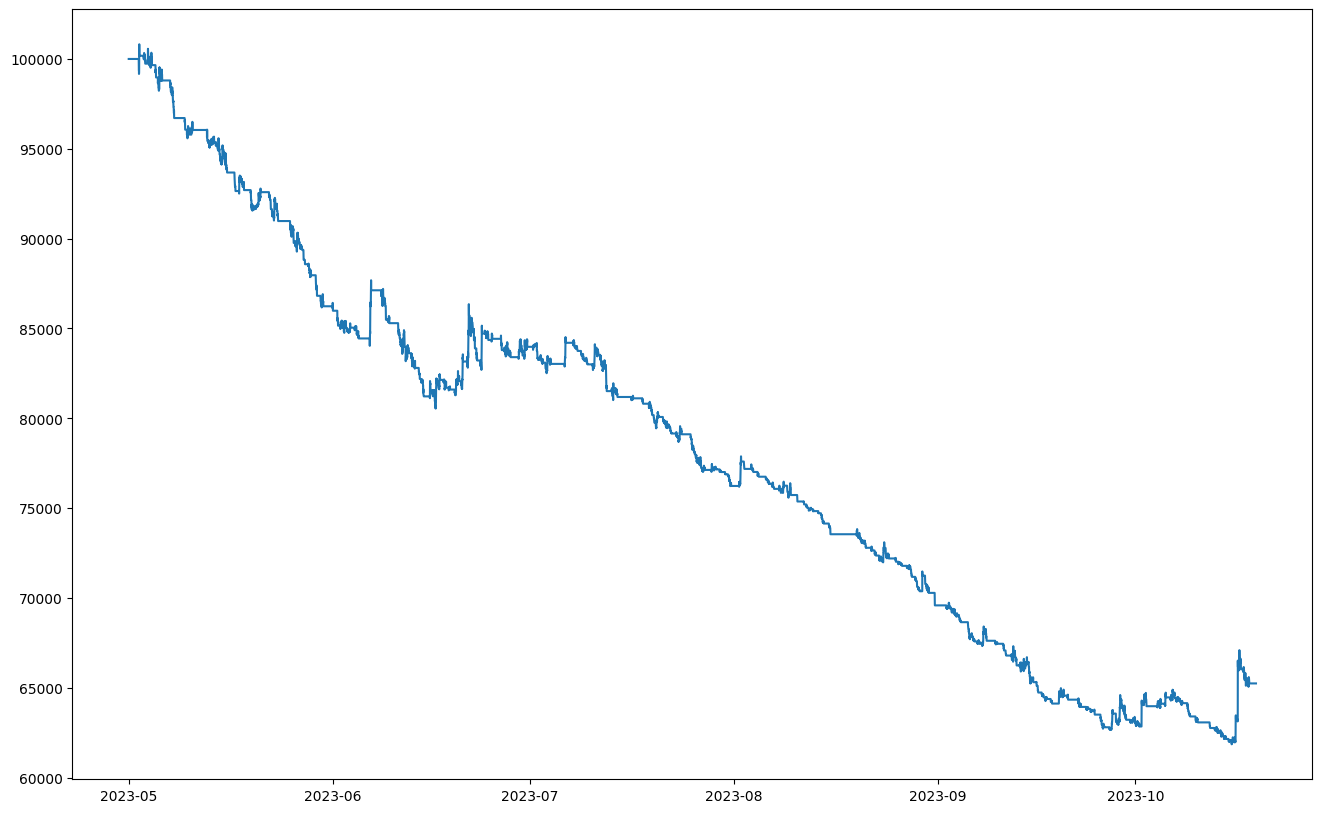

In [ ]:
import matplotlib.pyplot as plt

#stats['_equity_curve']
plt.figure(figsize=(16, 10))
plt.plot(stats['_equity_curve']['Equity'])
plt.show()